# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import torch

from unityagents import UnityEnvironment
from collections import deque
from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="unity/Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Train your agent

In the next code cell, agent will learn how to play Tennis.

if you have pretrained weight, you can load weight and skip training part

In [5]:
# Hyperparameters
LR = 1e-3
param = {
    "BUFFER_SIZE" : int(1e5),  # replay buffer size
    "BATCH_SIZE" : 256,        # minibatch size
    "GAMMA" : 0.99,            # discount factor
    "TAU" : 1e-3,              # for soft update of target parameters
    "LR_ACTOR" : LR,         # learning rate of the actor 
    "LR_CRITIC" : LR,        # learning rate of the critic
    "WEIGHT_DECAY" : 0.0000,   # L2 weight decay
    "LEARNING_REPEAT" : 20,     # updating the actor and critic networks LEARNING_REPEAT times
    "LEARNING_STEP" : 10        # at every LEARNING_STEP
}

In [6]:
# Set agent
agent = Agent(state_size, action_size, num_agents, param, 10)

# If you want, load pretrained weight
#agent.actor_local.load_state_dict(torch.load('pytorch_weight/checkpoint_actor_256_20_10_10_936_1.pt'))
#agent.critic_local.load_state_dict(torch.load('pytorch_weight/checkpoint_critic_256_20_10_10_936_1.pt'))

In [5]:
def save(param, agent, score_list, avg_score_list, i_episode, current_score):
    BATCH_SIZE = param["BATCH_SIZE"]
    LEARNING_REPEAT = param["LEARNING_REPEAT"]
    LR_ACTOR = param["LR_ACTOR"] / 1e-4
    LR_CRITIC = param["LR_CRITIC"] / 1e-4
    info_str = '_{}_{}_{:.0f}_{:.0f}_{}_{:.0f}'.format(BATCH_SIZE,LEARNING_REPEAT,LR_ACTOR,LR_CRITIC,i_episode, current_score)
    with open('score_log/score'+info_str+'.pk', 'wb') as f:
        pickle.dump(score_list, f)
    with open('score_log/avg_score'+info_str+'.pk', 'wb') as f:
        pickle.dump(avg_score_list, f)
    torch.save(agent.actor_local.state_dict(), 'pytorch_weight/checkpoint_actor'+info_str+'.pt')
    torch.save(agent.critic_local.state_dict(), 'pytorch_weight/checkpoint_critic'+info_str+'.pt')

In [6]:
def ddpg(env, env_info, agent, num_agents, param, n_episodes=2000, max_t=1000):  
    scores_deque = deque(maxlen=100)
    score_list = []
    avg_score_list = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        starting_time = time.time()
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        agent.reset()
        scores = np.zeros(num_agents) 
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states
            scores += rewards
            if np.any(dones):                                  # exit loop if episode finished
                break

        proc_time = time.time()-starting_time

        score = np.max(scores)
        scores_deque.append(score)
        score_list.append(score)
        avg_score_list.append(np.mean(scores_deque))
        print('\rEpisode {}\tAverage Score: {:.2f} proc_time {:.1f} sec'.format(i_episode, np.mean(scores_deque),proc_time), end="")
        if(i_episode % 100 == 0):
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
        if(np.mean(scores_deque) >= 0.5):
            print('\rProblem is solved at Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
    save(param, agent, score_list, avg_score_list, i_episode, np.mean(scores_deque))
    return score_list, avg_score_list

In [8]:
score_list, avg_score_list = ddpg(env, env_info, agent, num_agents, param)

Episode 100	Average Score: 0.01 proc_time 0.2 sec
Episode 200	Average Score: 0.02 proc_time 0.2 sec
Episode 300	Average Score: 0.00 proc_time 0.2 sec
Episode 400	Average Score: 0.00 proc_time 0.2 sec
Episode 500	Average Score: 0.00 proc_time 0.2 sec
Episode 600	Average Score: 0.01 proc_time 0.2 sec
Episode 700	Average Score: 0.06 proc_time 0.7 sec
Episode 800	Average Score: 0.18 proc_time 0.2 sec
Episode 900	Average Score: 0.40 proc_time 0.6 secc
Problem is solved at Episode 936	Average Score: 0.52


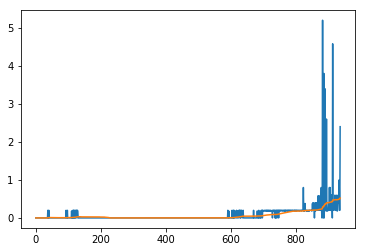

In [13]:
plt.plot(score_list)
plt.plot(avg_score_list)

### 4. Watch a Smart Agent!

In [7]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states)                        # select an action (for each agent)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.19000000320374966
Score (max over agents) from episode 2: 0.10000000149011612
Score (max over agents) from episode 3: 0.10000000149011612
Score (max over agents) from episode 4: 2.600000038743019
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [8]:
env.close()